In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812364 sha256=67f6b24bb1cbcd70babed65a8b13ec79409e90403e6a5c4f8cab4b9557d60c32
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder \
    .appName("ML Model") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/17 09:44:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# **Set_Up**
# 

Import Libraries

In [3]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col

# For data manipulation and analysis
import pandas as pd

# For visualization if needed after converting PySpark DataFrames to pandas
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


In [5]:
from pyspark.sql import functions as F

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


In [6]:
# Load the datasets
train_data = spark.read.csv('/kaggle/input/fraud-detection/fraudTrain.csv', header=True, inferSchema=True)
test_data = spark.read.csv('/kaggle/input/fraud-detection/fraudTest.csv', header=True, inferSchema=True)

# Display basic information about the datasets
print("Train Data Info:")
train_data.printSchema()
train_data.describe().show()

print("\nTest Data Info:")
test_data.printSchema()
test_data.describe().show()


Train Data Info:
root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



24/09/17 09:44:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/09/17 09:44:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , cc_num, merchant, category, amt, first, last, gender, street, city, state, zip, lat, long, city_pop, job, trans_num, unix_time, merch_lat, merch_long, is_fraud
 Schema: _c0, cc_num, merchant, category, amt, first, last, gender, street, city, state, zip, lat, long, city_pop, job, trans_num, unix_time, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///kaggle/input/fraud-detection/fraudTrain.csv


+-------+-----------------+--------------------+-------------------+-------------+-----------------+-------+-------+-------+--------------------+-------+-------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+--------------------+
|summary|              _c0|              cc_num|           merchant|     category|              amt|  first|   last| gender|              street|   city|  state|               zip|              lat|              long|          city_pop|               job|           trans_num|           unix_time|         merch_lat|        merch_long|            is_fraud|
+-------+-----------------+--------------------+-------------------+-------------+-----------------+-------+-------+-------+--------------------+-------+-------+------------------+-----------------+------------------+------------------+------------------+--------------------+----------

24/09/17 09:45:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , cc_num, merchant, category, amt, first, last, gender, street, city, state, zip, lat, long, city_pop, job, trans_num, unix_time, merch_lat, merch_long, is_fraud
 Schema: _c0, cc_num, merchant, category, amt, first, last, gender, street, city, state, zip, lat, long, city_pop, job, trans_num, unix_time, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///kaggle/input/fraud-detection/fraudTest.csv


+-------+-----------------+--------------------+-------------------+-------------+------------------+-------+------+------+--------------------+-------+------+------------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-----------------+------------------+--------------------+
|summary|              _c0|              cc_num|           merchant|     category|               amt|  first|  last|gender|              street|   city| state|               zip|              lat|              long|         city_pop|               job|           trans_num|           unix_time|        merch_lat|        merch_long|            is_fraud|
+-------+-----------------+--------------------+-------------------+-------------+------------------+-------+------+------+--------------------+-------+------+------------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+

In [33]:
train_data.show(5)
test_data.show(5)

+---------------------+------------+--------------------+------------+-----+------+------+------+--------------------+------+-----+-----+-------+--------+--------+-----------------+----------+--------------------+----------+------------------+----------+--------+----------+---------+----------+-------------------+---------------------------+---+
|trans_date_trans_time|      cc_num|            merchant|    category|  amt| first|  last|gender|              street|  city|state|  zip|    lat|    long|city_pop|              job|       dob|           trans_num| unix_time|         merch_lat|merch_long|is_fraud|trans_hour|trans_day|trans_date|       unix_time_ts|time_since_last_transaction|age|
+---------------------+------------+--------------------+------------+-----+------+------+------+--------------------+------+-----+-----+-------+--------+--------+-----------------+----------+--------------------+----------+------------------+----------+--------+----------+---------+----------+---------

In [7]:
# Dropping the _c0 column if it exists
train_data = train_data.drop('_c0')
test_data = test_data.drop('_c0')

In [8]:
# Check for missing values in both datasets
from pyspark.sql.functions import col, sum

print("\nMissing Values in Train Data:")
train_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in train_data.columns]).show()

print("\nMissing Values in Test Data:")
test_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in test_data.columns]).show()



Missing Values in Train Data:


+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|
+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+


Missing Values in Test Data:


+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|
+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+



In [9]:
# Removing rows with missing values
# ---------------------------------
# because it's just a single row in each set,
# that's why there will be no huge data loss.

train_data = train_data.dropna()
test_data = test_data.dropna()


In [10]:
# Display summary statistics of the train dataset
print("\nTrain Data Summary Statistics:")
train_data.describe().show()



Train Data Summary Statistics:


+-------+--------------------+-------------------+-------------+-----------------+-------+-------+-------+--------------------+-------+-------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+--------------------+
|summary|              cc_num|           merchant|     category|              amt|  first|   last| gender|              street|   city|  state|               zip|              lat|              long|          city_pop|               job|           trans_num|           unix_time|         merch_lat|        merch_long|            is_fraud|
+-------+--------------------+-------------------+-------------+-----------------+-------+-------+-------+--------------------+-------+-------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+-----

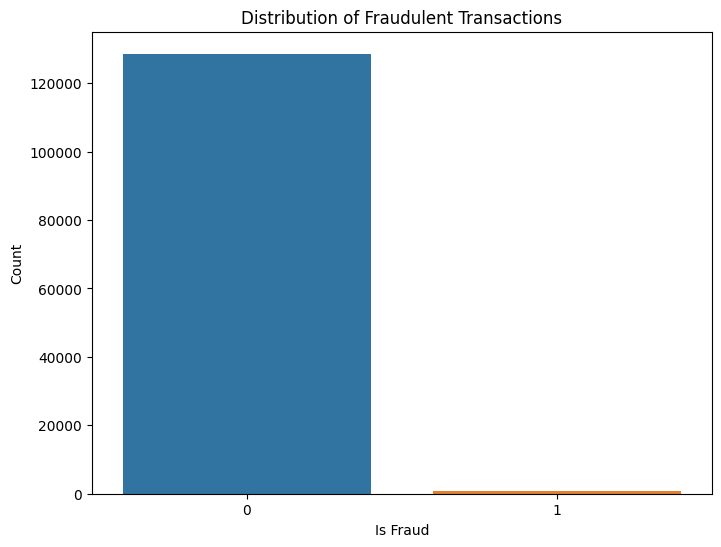

In [11]:
# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Visualize the distribution of the target variable (fraudulent or not)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='is_fraud', data=train_data_sample)
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()



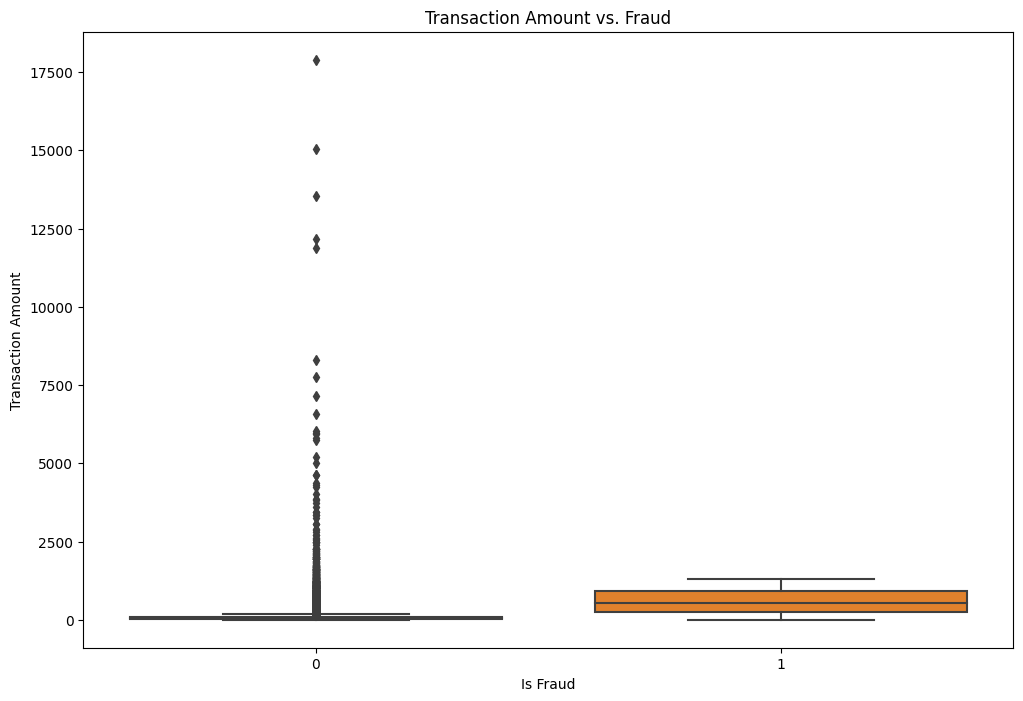

In [12]:
# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Explore the distribution of transaction amounts by fraud status
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x='is_fraud', y='amt', data=train_data_sample)
plt.title('Transaction Amount vs. Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.show()


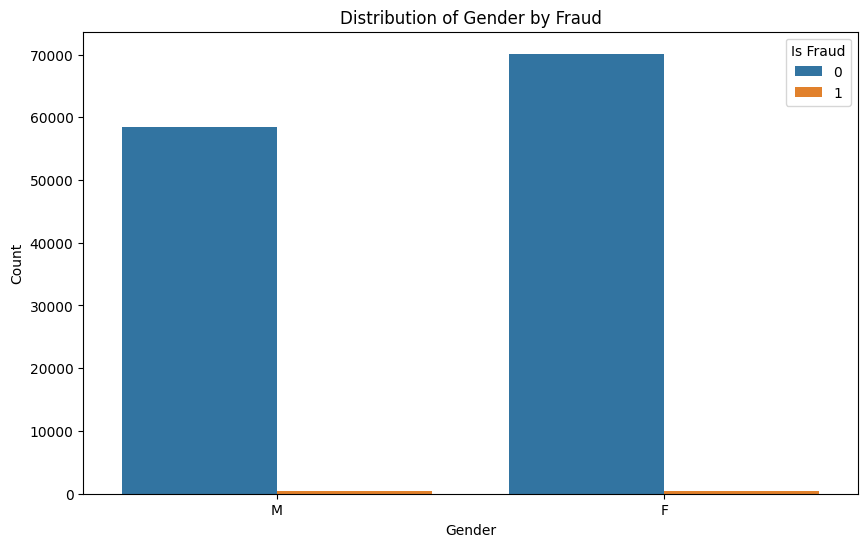

In [13]:
# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Explore categorical features (e.g., gender)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='is_fraud', data=train_data_sample)
plt.title('Distribution of Gender by Fraud')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Is Fraud')
plt.show()


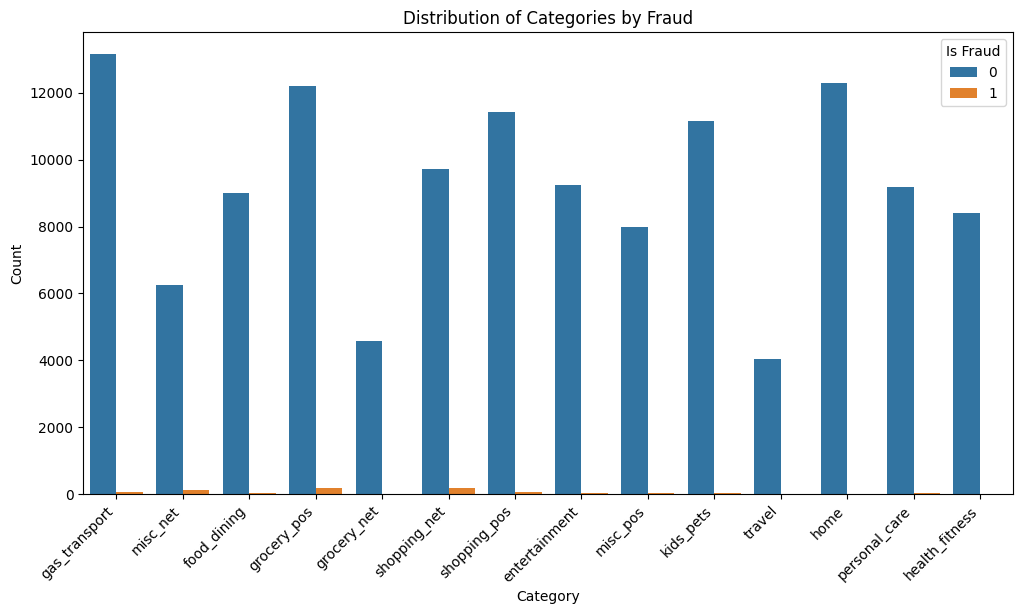

In [14]:
# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Explore the distribution of categories by fraud status
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(x='category', hue='is_fraud', data=train_data_sample)
plt.title('Distribution of Categories by Fraud')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Is Fraud')
plt.show()


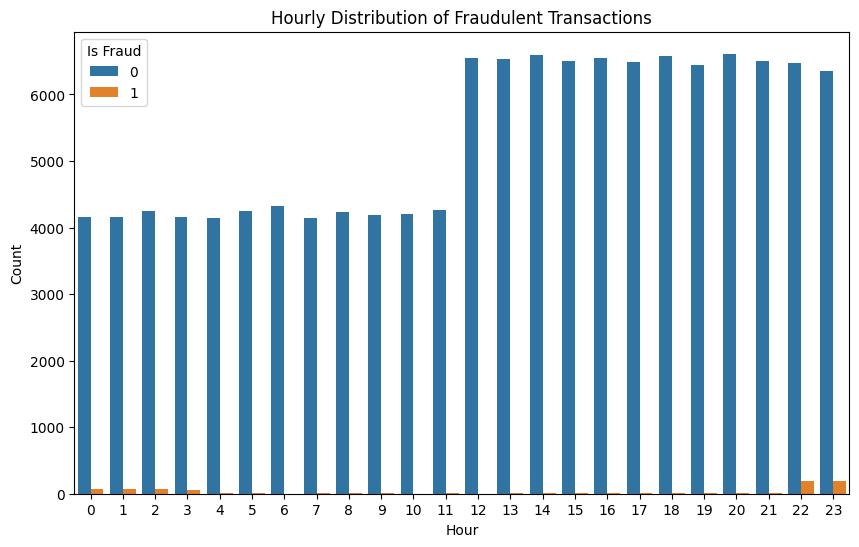

In [15]:
from pyspark.sql.functions import hour, dayofweek, col

# Time analysis: Extract hours and days from 'trans_date_trans_time'
train_data = train_data.withColumn('trans_hour', hour(col('trans_date_trans_time')))
train_data = train_data.withColumn('trans_day', dayofweek(col('trans_date_trans_time')))

# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Plot hourly distribution of fraud
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='trans_hour', hue='is_fraud', data=train_data_sample)
plt.title('Hourly Distribution of Fraudulent Transactions')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.legend(title='Is Fraud')
plt.show()


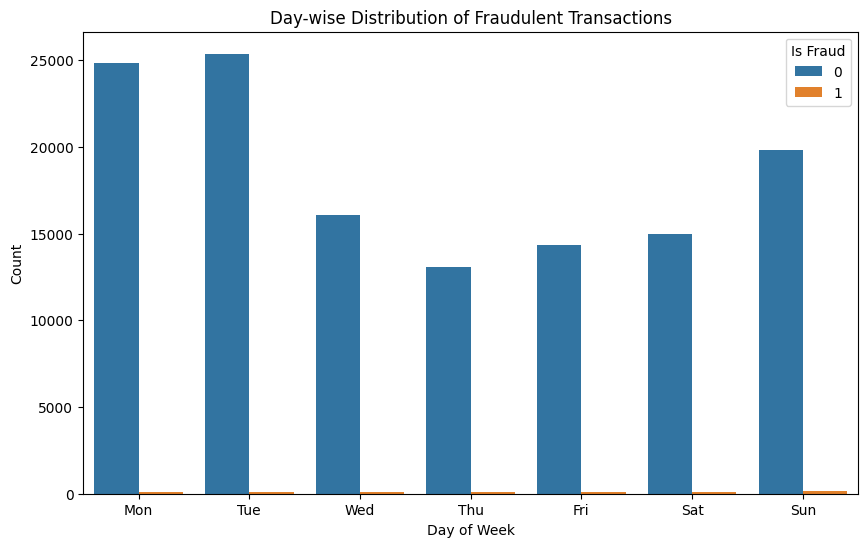

In [16]:
# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Plot day-wise distribution of fraud
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='trans_day', hue='is_fraud', data=train_data_sample)
plt.title('Day-wise Distribution of Fraudulent Transactions')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(title='Is Fraud')
plt.show()


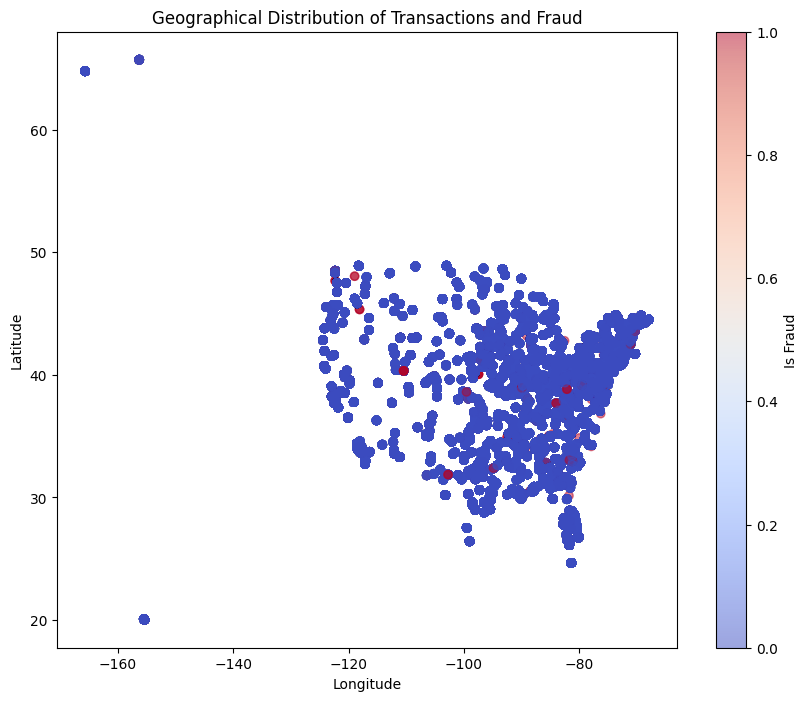

In [17]:
# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Scatter plot of geographical data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(train_data_sample['long'], train_data_sample['lat'], c=train_data_sample['is_fraud'], cmap='coolwarm', alpha=0.5)
plt.title('Geographical Distribution of Transactions and Fraud')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Is Fraud')
plt.show()


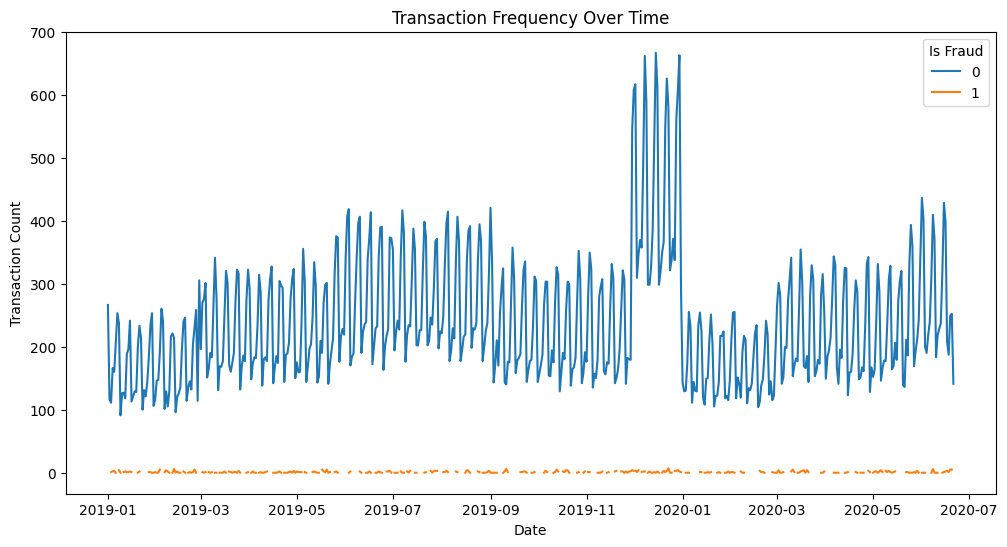

In [18]:
from pyspark.sql.functions import to_date, col

# Convert the timestamp to date
train_data = train_data.withColumn('trans_date', to_date(col('trans_date_trans_time')))

# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Group by date and fraud status, then plot
transaction_counts = train_data_sample.groupby(['trans_date', 'is_fraud']).size().unstack()
transaction_counts.plot(kind='line', figsize=(12, 6))
plt.title('Transaction Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.legend(title='Is Fraud')
plt.show()



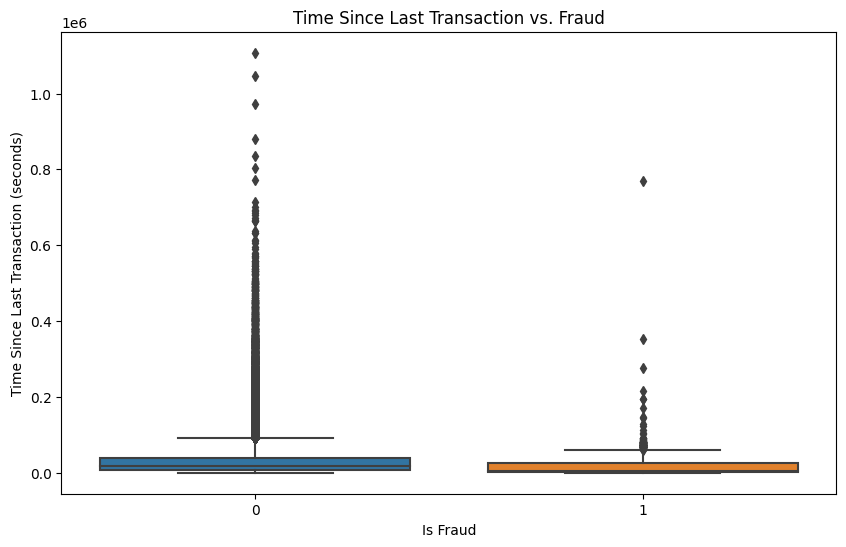

In [19]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, unix_timestamp, from_unixtime

# Convert unix_time to timestamp
train_data = train_data.withColumn('unix_time_ts', from_unixtime(col('unix_time')))

# Calculate the time since the last transaction
window_spec = Window.partitionBy('cc_num').orderBy('unix_time_ts')
train_data = train_data.withColumn('time_since_last_transaction', unix_timestamp(col('unix_time_ts')) - unix_timestamp(lag(col('unix_time_ts'), 1).over(window_spec)))

# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Plot time since last transaction vs. fraud
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='time_since_last_transaction', data=train_data_sample)
plt.title('Time Since Last Transaction vs. Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Time Since Last Transaction (seconds)')
plt.show()

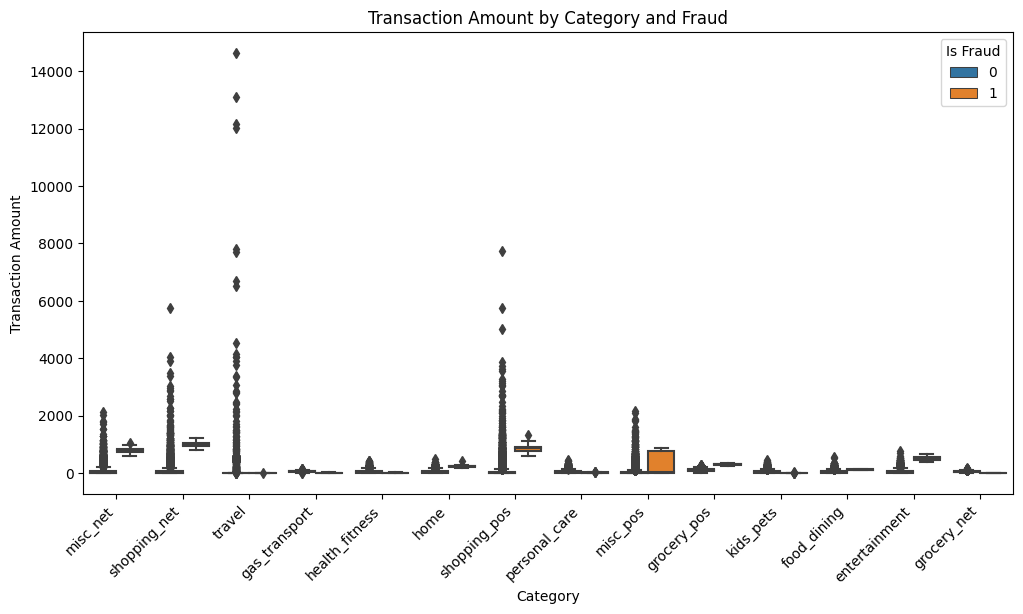

In [20]:
# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Plot transaction amount by category and fraud
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='amt', hue='is_fraud', data=train_data_sample)
plt.title('Transaction Amount by Category and Fraud')
plt.xlabel('Category')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Is Fraud')
plt.show()


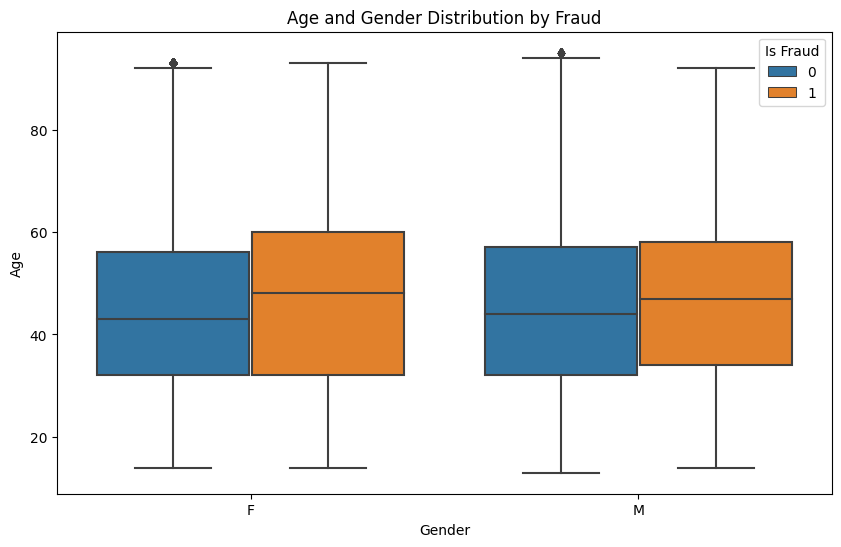

In [21]:
from pyspark.sql.functions import col, datediff, to_date

# Convert 'dob' to date and calculate 'age'
train_data = train_data.withColumn('dob', to_date(col('dob')))
train_data = train_data.withColumn('age', (datediff(col('trans_date_trans_time'), col('dob')) / 365).cast('int'))

# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Plot age and gender distribution by fraud
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='age', hue='is_fraud', data=train_data_sample)
plt.title('Age and Gender Distribution by Fraud')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.legend(title='Is Fraud')
plt.show()


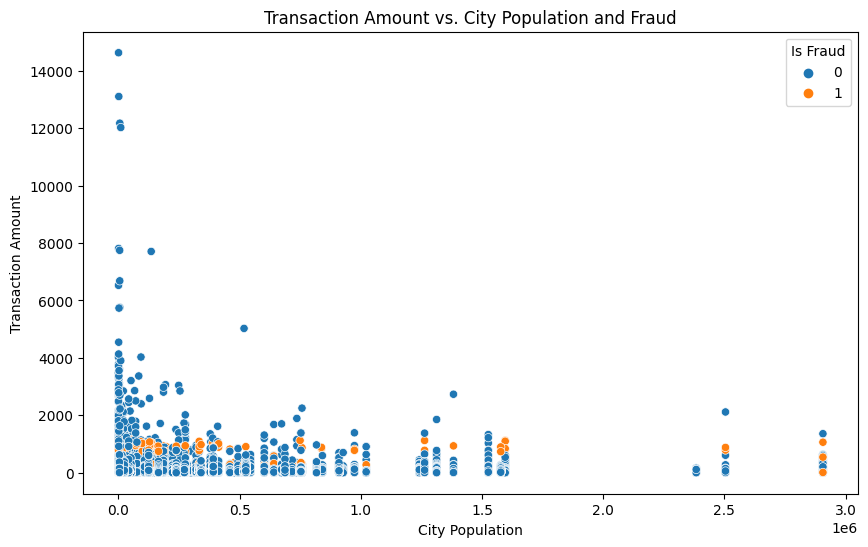

In [22]:
# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Plot transaction amount vs. city population and fraud
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='city_pop', y='amt', hue='is_fraud', data=train_data_sample)
plt.title('Transaction Amount vs. City Population and Fraud')
plt.xlabel('City Population')
plt.ylabel('Transaction Amount')
plt.legend(title='Is Fraud')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


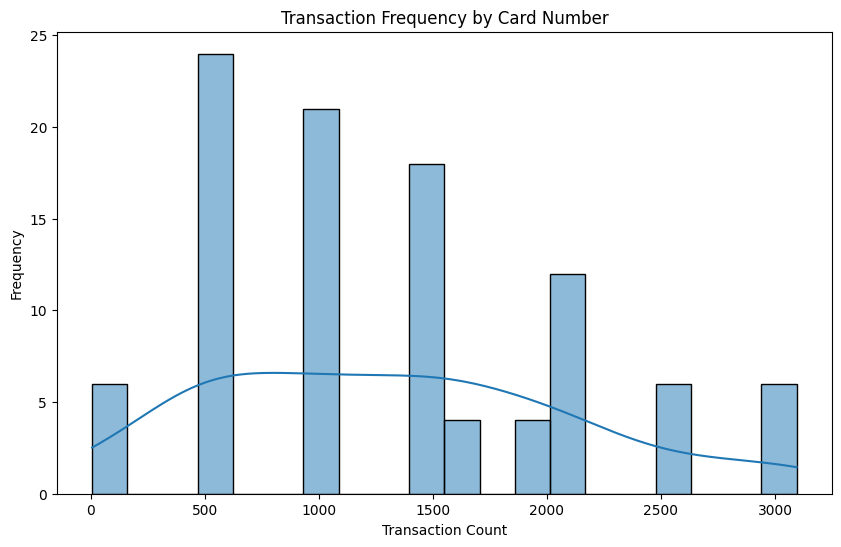

In [23]:
from pyspark.sql.functions import col

# Count the number of transactions per card number
card_transaction_counts = train_data.groupBy('cc_num').count()

# Sample a smaller subset of the data for visualization
card_transaction_counts_sample = card_transaction_counts.sample(fraction=0.1, seed=42).toPandas()

# Plot transaction frequency by card number
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(card_transaction_counts_sample['count'], bins=20, kde=True)
plt.title('Transaction Frequency by Card Number')
plt.xlabel('Transaction Count')
plt.ylabel('Frequency')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

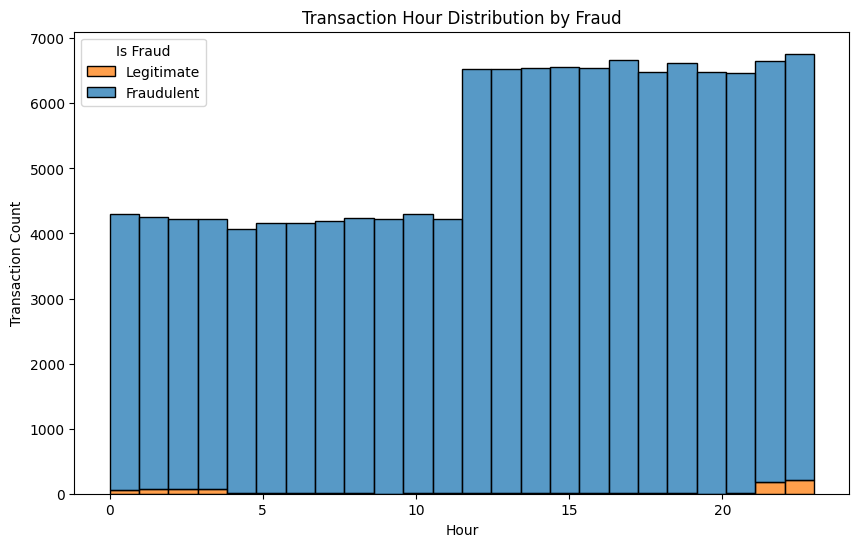

In [24]:
from pyspark.sql.functions import hour, col

# Extract the hour from 'trans_date_trans_time'
train_data = train_data.withColumn('trans_hour', hour(col('trans_date_trans_time')))

# Sample a smaller subset of the data for visualization
train_data_sample = train_data.sample(fraction=0.1, seed=42).toPandas()

# Plot transaction hour distribution by fraud
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=train_data_sample, x='trans_hour', hue='is_fraud', multiple='stack', bins=24)
plt.title('Transaction Hour Distribution by Fraud')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
plt.legend(title='Is Fraud', labels=['Legitimate', 'Fraudulent'])
plt.show()


In [28]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, sum
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Encode categorical variables
indexers = [StringIndexer(inputCol=col, outputCol=col + '_index').fit(train_data) for col in ['gender', 'category', 'state']]
encoders = [OneHotEncoder(inputCols=[col + '_index'], outputCols=[col + '_vec']) for col in ['gender', 'category', 'state']]

# Assemble features
assembler = VectorAssembler(
    inputCols=['gender_vec', 'category_vec', 'state_vec'] + 
               ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long'],
    outputCol='features'
)

# Scaling
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])

# Fit and transform training data
pipeline_model = pipeline.fit(train_data)
train_transformed = pipeline_model.transform(train_data)
test_transformed = pipeline_model.transform(test_data)


In [32]:
from pyspark.ml.feature import VectorAssembler

# Assuming 'train_transformed' is your DataFrame with features and target column
assembler = VectorAssembler(inputCols=[col for col in train_transformed.columns if col != 'is_fraud'], outputCol='features')
assembled_df = assembler.transform(train_transformed)

# Show a sample
assembled_df.select('features', 'is_fraud').show(5)


IllegalArgumentException: Data type timestamp of column trans_date_trans_time is not supported.
Data type string of column merchant is not supported.
Data type string of column category is not supported.
Data type string of column first is not supported.
Data type string of column last is not supported.
Data type string of column gender is not supported.
Data type string of column street is not supported.
Data type string of column city is not supported.
Data type string of column state is not supported.
Data type string of column job is not supported.
Data type date of column dob is not supported.
Data type string of column trans_num is not supported.
Data type date of column trans_date is not supported.
Data type string of column unix_time_ts is not supported.

In [31]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

# Convert SparseVector to Dense Array
def sparse_to_dense(v):
    return v.toArray().tolist()

# Register the UDF
sparse_to_dense_udf = udf(sparse_to_dense, ArrayType(DoubleType()))

# Apply the UDF to convert features
train_transformed_dense = train_transformed.withColumn('features_dense', sparse_to_dense_udf('scaled_features'))

# Convert to Pandas DataFrame
train_pd = train_transformed_dense.select('features_dense', 'is_fraud').toPandas()

# Extract features and target variable
X = pd.DataFrame(train_pd['features_dense'].tolist())
y = train_pd['is_fraud'].values

# Apply SMOTE
smote = SMOTE(random_state=36)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
resampled_df = pd.DataFrame(X_resampled, columns=[f'feature_{i}' for i in range(X_resampled.shape[1])])
resampled_df['is_fraud'] = y_resampled

# Convert Pandas DataFrame back to Spark DataFrame
resampled_spark_df = spark.createDataFrame(resampled_df)



24/09/17 10:06:34 ERROR Utils: Uncaught exception in thread driver-heartbeater  
java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.executor.ExecutorMetrics$.getCurrentMetrics(ExecutorMetrics.scala:100)
	at org.apache.spark.SparkContext.reportHeartBeat(SparkContext.scala:2781)
	at org.apache.spark.SparkContext.$anonfun$new$23(SparkContext.scala:592)
	at org.apache.spark.SparkContext$$Lambda$688/0x00000008405c0040.apply$mcV$sp(Unknown Source)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.runAndReset(FutureTask.java:305)
	at java.base/java.util.concurrent.ScheduledThreadPoolExecutor$ScheduledFutureTask.run(ScheduledThreadPoolExecutor.java:305)
	at java.base/java.util.concurrent.

Py4JJavaError: An error occurred while calling o995.collectToPython.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.execution.SparkPlan$$anon$1._next(SparkPlan.scala:415)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.getNext(SparkPlan.scala:426)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.getNext(SparkPlan.scala:412)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.util.NextIterator.foreach(NextIterator.scala:21)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1(SparkPlan.scala:449)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1$adapted(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$3869/0x00000008415b4840.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4150)
	at org.apache.spark.sql.Dataset$$Lambda$3900/0x00000008415dd040.apply(Unknown Source)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4324)
	at org.apache.spark.sql.Dataset$$Lambda$2103/0x0000000840ef8840.apply(Unknown Source)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4322)
	at org.apache.spark.sql.Dataset$$Lambda$1755/0x0000000840d7a840.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1766/0x0000000840d80840.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1756/0x0000000840d7ac40.apply(Unknown Source)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4322)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4147)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
